In [1]:
import gensim
import os
import string
import itertools
from nltk.corpus import brown, movie_reviews, treebank, webtext, gutenberg
import sense2vec
from operator import itemgetter
from joke_model import JokeModel
from language_models import Sense2VecModel, Word2VecModel
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
def load_stopwords(fname='stopwords.txt'):
    # stopwords =  ['a','to','of', 'so', 'on', 'the', 'into']
    # stopwords += ['i', 'me', 'my', 'you', 'us', 'we', 'them', 'she', 'her', 'he', 'him']
    # stopwords += ['and', 'or', 'but']
    # stopwords += ['had', 'have', "'ve"]
    # stopwords += ['is', 'are', 'am', "'m", 'be']
    # stopwords += ["'s", "'d"]
    stopWords = set(stopwords.words('english'))
    return stopWords

In [3]:
def load_stoptags(fname='stoppos.txt'):
    allpos = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 
            'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'NORP', 
            'FACILITY', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LANGUAGE']
    keeppos = ['ADJ', 'ADV', 'INTJ', 'NOUN',  
            'PROPN', 'SCONJ', 'SYM', 'VERB', 'X', 'NORP', 
            'FACILITY', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART', 'LANGUAGE']
    stoppos = list(set(allpos) - set(keeppos))
    return stoppos


In [4]:
def get_similarities(this_model, joke):
    max_sim = -1.0
    min_sim = 1.0
    max_words = ()
    min_words = ()

    stop_words = load_stopwords()
    stop_tags = load_stoptags()

    # remove stopwords
    joke_words = [w for w in joke.split() if w.split('|')[0].lower() not in stop_words]
    # remove unwanted tags
    joke_words = [w for w in joke_words if w.split('|')[1] not in stop_tags]
    # remove OOV words
    joke_words = [w for w in joke_words if this_model.in_vocab(w)]

    sim_grid = pd.DataFrame(index=joke_words, columns=joke_words)
    sim_grid = sim_grid.fillna(-1.0)

    pairs = list(itertools.combinations(joke_words,2))
    for (left_word,right_word) in pairs:
        if not (left_word == right_word):
            try:
                this_sim = this_model.similarity(left_word, right_word)
                sim_grid[left_word][right_word] = max(sim_grid[left_word][right_word], this_sim)

                if this_sim < min_sim:
                    min_sim = this_sim
                    min_words = (left_word, right_word)
                if this_sim > max_sim:
                    max_sim = this_sim
                    max_words = (left_word, right_word)
            except:
                # use this to build a stopword list
                print("one of these words is not in vocab: {0}, {1}".format(left_word,right_word))
    return [min_sim, min_words, max_sim, max_words, sim_grid, joke, joke_words]


In [5]:
def main(model_choice='s2v',joke_choice='jokes.txt'):
    print("Load the model")
    if model_choice == 'w2v':
        print(">>word2vec - extended corpora")
        model = Word2VecModel(model_choice)
    elif model_choice == 's2v':
        print(">>sense2vec - reddit hivemind corpus")
        model = Sense2VecModel(model_choice)
    else:
        raise NotImplementedError

    try:
        print("Load the jokes")
        jokes = JokeModel(joke_choice,named_entities=False)
    except:
        raise Exception('Could not load file "'+joke_choice+'"')


    results = [[j,None,None,[None]] for j in jokes.raw_jokes()]
    joke_id = 0
    for joke in jokes.tagged_jokes():
        print(results[joke_id][0])
        mns, mnw, mxs, mxw, grid, pos_joke, pos_joke_words = get_similarities(model, joke)
        results[joke_id][1] = pos_joke
        results[joke_id][2] = pos_joke_words
        results[joke_id][3] = grid
        joke_id += 1
        
    with open(model_choice+'_'+joke_choice+'.pkl','wb') as pkl_file:
        pickle.dump(results, pkl_file)



In [6]:
# This is the main function as free code

model_choice='s2v'
joke_choice='jokes.txt'

print("Load the model")
if model_choice == 'w2v':
    print(">>word2vec - extended corpora")
    model = Word2VecModel(model_choice)
elif model_choice == 's2v':
    print(">>sense2vec - reddit hivemind corpus")
    model = Sense2VecModel(model_choice)
else:
    raise NotImplementedError

try:
    print("Load the jokes")
    jokes = JokeModel(joke_choice,named_entities=False)
except:
    raise Exception('Could not load file "'+joke_choice+'"')


results = [[j,None,None,[None],None] for j in jokes.raw_jokes()]
joke_id = 0
for joke in jokes.tagged_jokes():
    print(results[joke_id][0])
    mns, mnw, mxs, mxw, grid, pos_joke, pos_joke_words = get_similarities(model, joke)
    results[joke_id][1] = pos_joke
    results[joke_id][2] = pos_joke_words
    results[joke_id][3] = grid
    if model_choice == 's2v':
        results[joke_id][4] = model.entropy(pos_joke_words)
        print(entropy: results[joke_id][4])
    joke_id += 1


Load the model
>>sense2vec - reddit hivemind corpus
counting tokens
Load the jokes
i wasn't originally going to get a brain transplant, but then i changed my mind.
i was going to get a brain transplant and then i changed my mind.
i'd tell you a chemistry joke but i know i wouldn't get a reaction.
i'm glad i know sign language, it's pretty handy.
i have a few jokes about unemployed people but it doesn't matter none of them work.
i used to be a banker, but then i lost interest.
i hate insects puns, they really bug me.
insect puns bug me.
it's hard to explain puns to kleptomaniacs because they always take things literally.
i was so sad and crying when i lost my playstation 3 but unfortunately, there was nobody to console me!
i'm on a whiskey diet. i've lost three days already.
she broke into song when she couldn't find the key.
she had a boyfriend with a wooden leg, but broke it off.
corduroy pillows are making headlines.
if you want to catch a squirrel just climb a tree and act like a nu

In [7]:
 model.entropy("insect|ADJ puns|NOUN bug|NOUN")

0.00034796390626760031

In [45]:
results = [[j,None,None,[None],None] for j in jokes.raw_jokes()]
for joke_id, joke in enumerate(jokes.tagged_jokes()):
    print(results[joke_id][0])
    mns, mnw, mxs, mxw, grid, pos_joke, pos_joke_words = get_similarities(model, joke)
    results[joke_id][1] = pos_joke
    results[joke_id][2] = pos_joke_words
    results[joke_id][3] = grid
    if model_choice == 's2v':
        # results[joke_id][4] = model.entropy(' '.join(pos_joke_words))
        entropy = 0.0
        string = ''
        cumulative_entropy = []
        for w in pos_joke_words:
            string = string + ' ' + w
            cumulative_entropy += [model.entropy(string)]
        results[joke_id][4] = cumulative_entropy
        print('entropy: {}'.format(cumulative_entropy))

i wasn't originally going to get a brain transplant, but then i changed my mind.
entropy: [0.00031166274098614108, 0.0084508923974274171, 0.025236242839423044, 0.025743917959190142, 0.025757652319476541, 0.026747382089289298, 0.028440396004565528]
i was going to get a brain transplant and then i changed my mind.
entropy: [0.0081392296564412759, 0.024924580098436899, 0.025432255218203997, 0.025445989578490397, 0.026435719348303154, 0.028128733263579384]
i'd tell you a chemistry joke but i know i wouldn't get a reaction.
entropy: [0.0072470070774240921, 0.010283810456805362, 0.01036150684026343, 0.011182061039004692, 0.022968913705007116, 0.042723735824662629, 0.059509086266658254, 0.059770505979879221]
i'm glad i know sign language, it's pretty handy.
entropy: [0.00092923127186628142, 0.012716083937868708, 0.012992015275015523, 0.013363062712515753, 0.018473951575714471, 0.018599006850386089]
i have a few jokes about unemployed people but it doesn't matter none of them work.
entropy: [0

In [125]:
def plot_entropy(this_joke):
    # twin scales code suggested by https://matplotlib.org/devdocs/gallery/api/two_scales.html
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    cum_val = 0
    individual_entropies = []
    for each_sum in this_joke[4]:
        this_val = each_sum - cum_val
        individual_entropies += [this_val]
        cum_val = each_sum

    ax1.plot(this_joke[4])
    ax1.plot(individual_entropies)
    ax1.set_ylabel('Entropy (nat)')
    
    maxes = this_joke[3].replace(-1,np.nan).max(axis=1).tolist()
    mins = this_joke[3].replace(-1,np.nan).min(axis=1).tolist()

    ax2.plot(maxes,'g^',linestyle='None')
    ax2.plot(mins,'gv',linestyle='None')
#    ax2.plot(this_joke[3].replace(-1,np.nan))

#     plt.xticks(range(len(this_joke[2])),this_joke[2],rotation=23)
    ax1.set_xticks(ticks=range(len(this_joke[2])))
    ax1.set_xticklabels(this_joke[2],rotation=23)
    plt.show()

def plot_entropy_works(this_joke):
    
    fig, ax = plt.subplots()
    ax1, ax2 = two_scales(ax, t, s1, s2, 'r', 'b')

    cum_val = 0
    individual_entropies = []
    for each_sum in this_joke[4]:
        this_val = each_sum - cum_val
        individual_entropies += [this_val]
        cum_val = each_sum

    plt.plot(this_joke[4])
    plt.plot(individual_entropies)
    plt.ylabel('some numbers')
    plt.xticks(range(len(this_joke[2])),this_joke[2],rotation=23)
    plt.show()

In [109]:
print(type(results[10][3]))
maxes = results[10][3].replace(-1,np.nan).max(axis=1)
mins = results[10][3].replace(-1,np.nan).min(axis=1)

print(maxes)
print(mins)
print(maxes.index.values)

<class 'pandas.core.frame.DataFrame'>
whiskey|NOUN         NaN
diet|NOUN       0.358023
lost|VERB       0.271953
three|DATE      0.350585
days|DATE       0.499580
already|ADV     0.578484
dtype: float64
whiskey|NOUN         NaN
diet|NOUN       0.358023
lost|VERB       0.143448
three|DATE      0.193936
days|DATE       0.279796
already|ADV     0.176032
dtype: float64
['whiskey|NOUN' 'diet|NOUN' 'lost|VERB' 'three|DATE' 'days|DATE'
 'already|ADV']


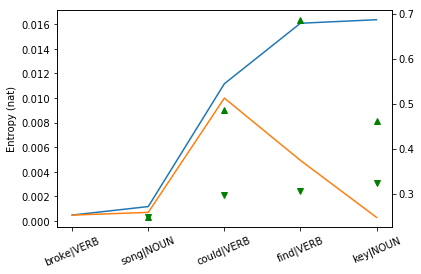

In [126]:
plot_entropy(results[11])

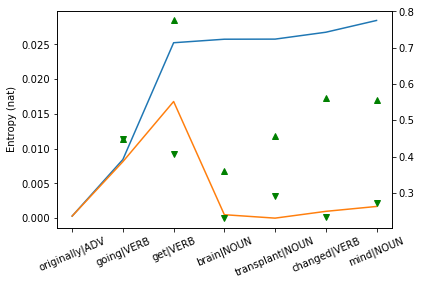

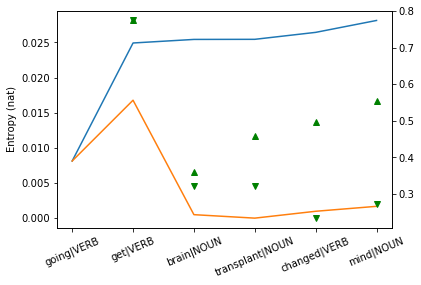

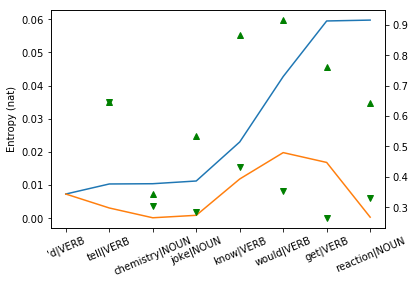

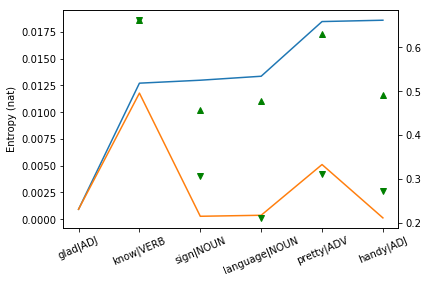

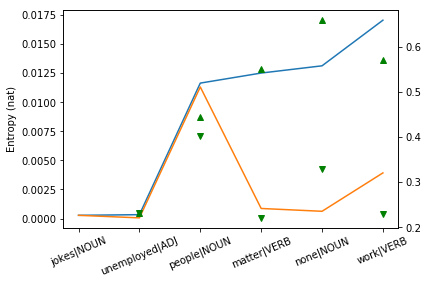

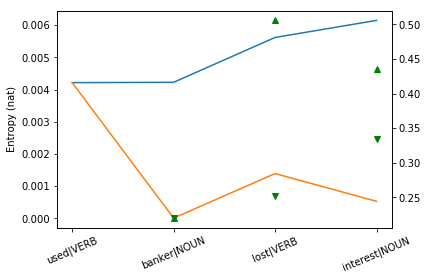

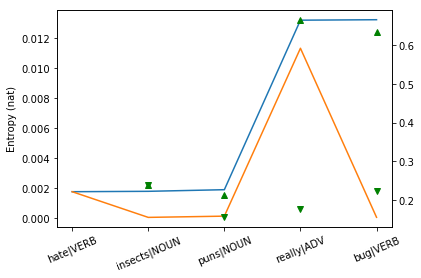

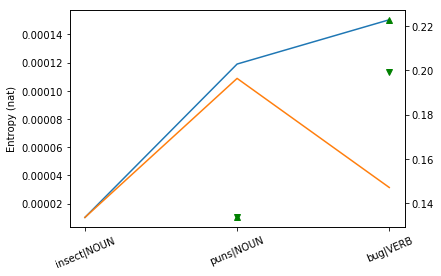

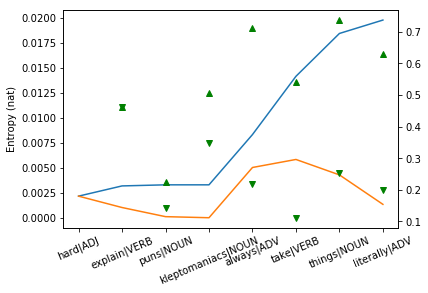

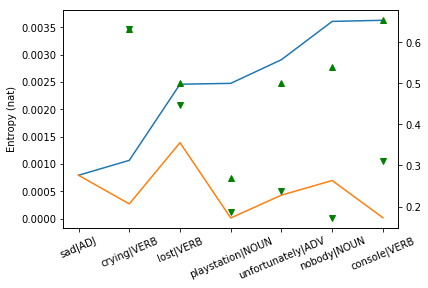

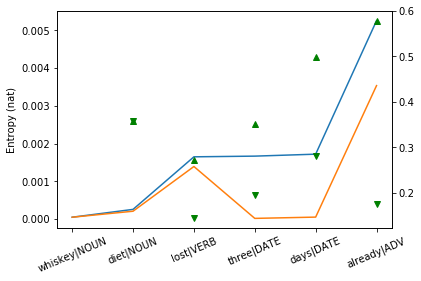

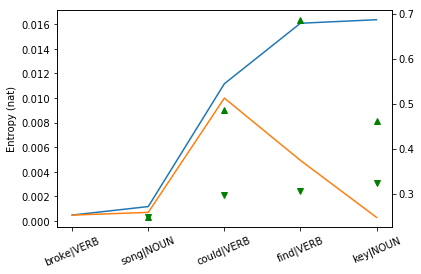

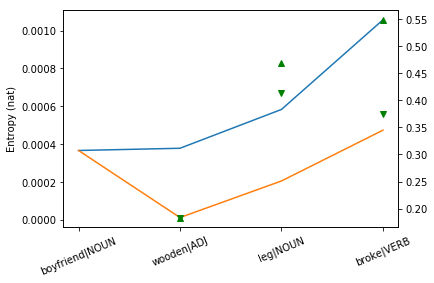

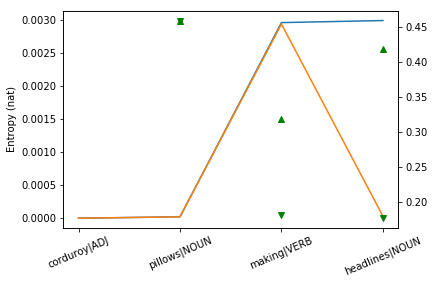

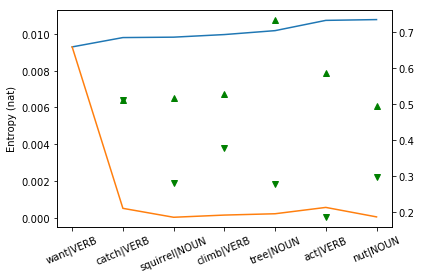

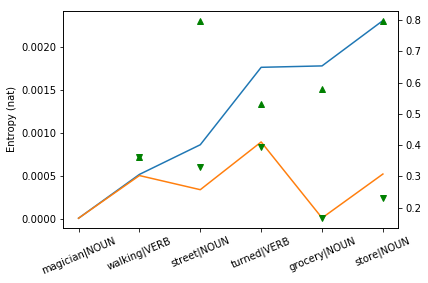

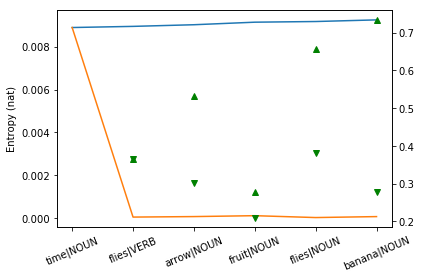

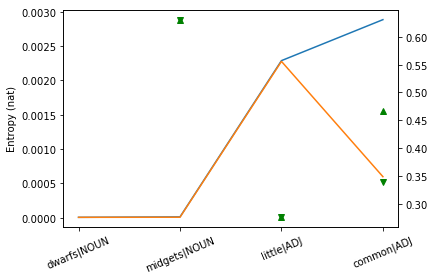

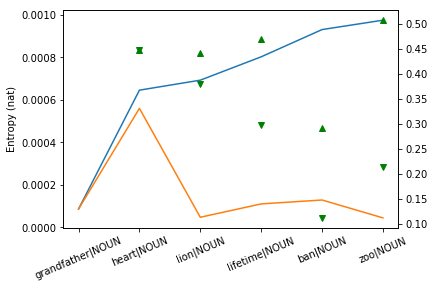

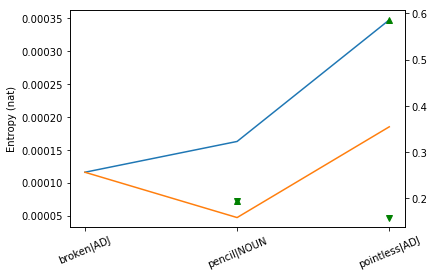

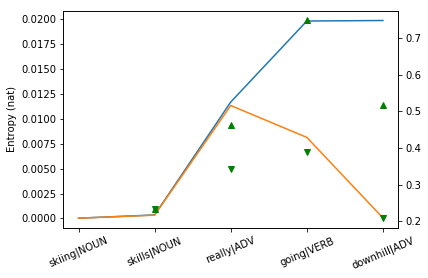

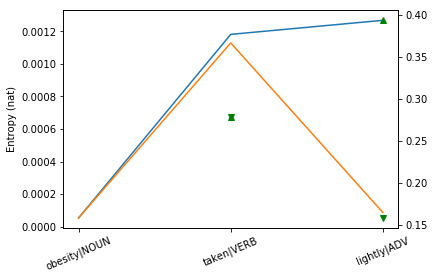

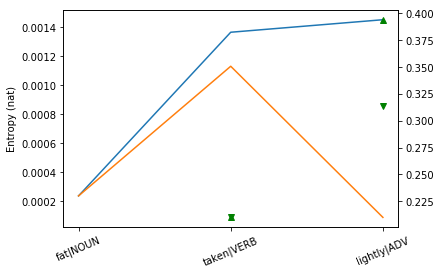

In [127]:
for r in results:
    plot_entropy(r)